In [1]:
%matplotlib inline
from __future__ import division
import h5py
import numpy as np
import lockin
import sigutils
from scipy import signal
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import phasekick
import glob
from tqdm import tqdm
import pandas as pd
idx = pd.IndexSlice


def gr2locks(top_gr):
    locks = []
    for gr in tqdm(top_gr.values()):
        half_periods = gr["half periods [s]"][:]
        N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
        t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
        t2 = np.sum(gr["half periods [s]"][:N2even+1])
        t0 = -(t1 + t2)
        x = gr['cantilever-nm'][:]
        dt = gr['dt [s]'].value
        t = np.arange(x.size)*dt + t0
        lock = lockin.LockIn(t, x, 1/dt)
        lock.lock2(fp=5000, fc=15000, print_response=False)
        lock.phase(ti=3e-3, tf=7e-3)
        locks.append(lock)
    
    return locks


def left_right_fit(x, y, xLi, xLf, xRi, xRf, x0):
    mL = phasekick.masklh(x, xLi, xLf)
    mR = phasekick.masklh(x, xRi, xRf)
    mbL = np.polyfit(x[mL], y[mL], 1)
    mbR = np.polyfit(x[mR], y[mR], 1)
    diff = np.polyval(mbR, x0) - np.polyval(mbL, x0)
    return mbL, mbR, diff

def measure_dA_dphi(li, tp, tLi, tLf, tRi, tRf):
    _, __, dA = left_right_fit(li.t, li.A, tLi, tLf, tp+tRi, tp+tRf, tp/2)
    _, __, dphi = left_right_fit(li.t, np.unwrap(li.phi), tLi, tLf, tp+tRi, tp+tRf, tp/2)
    return dA, dphi

def delay_dA_dphi(top_gr, tp, tLi, tLf, tRi, tRf):
    dAs=[]
    dPhis=[]
    delays =[]
    for ds_name, gr in tqdm(top_gr.items()):
        half_periods = gr["half periods [s]"][:]
        N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
        t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
        t2 = np.sum(gr["half periods [s]"][:N2even+1])
        t0 = -(t1 + t2)
        x = gr['cantilever-nm'][:]
        dt = gr['dt [s]'].value
        t = np.arange(x.size)*dt + t0
        li = lockin.LockIn(t, x, 1/dt)
        li.lock2(fp=5000, fc=15000, print_response=False)
        li.phase(ti=3e-3, tf=7e-3)
        dA, dphi = measure_dA_dphi(li, tp, tLi, tLf, tRi, tRf)
        dAs.append(dA)
        dPhis.append(dphi)
        delays.append(gr.attrs['Abrupt BNC565 CantClk.D tip [s]'])
    
    return delays, dAs, dPhis

In [2]:
size = 9
rcParams = {'figure.figsize': (2.0, 2.5), 'font.size': size,
#             'lines.markersize': ,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,}

In [3]:
fh = h5py.File('../data/subcycle-pk-efm/151209-192456-400ns-pulse-10V.h5', 'r')
delays, dA, dPhis = delay_dA_dphi(fh['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)

tps = [800, 400, 200, 100, 50]
# Set up DataFrame now that delay times are known
delay_int = np.int64(np.round(np.array(delays)*1e9))
df = pd.DataFrame(index=pd.MultiIndex.from_product(
        ([800, 400, 200, 100, 50], delay_int), names=['pulsewidth', 'delay']))
df.sort_index(inplace=True)

df.loc[idx[400, :], 'dA'] = dA
df.loc[idx[400, :], 'dPhi'] = dPhis

fh100 = h5py.File('../data/subcycle-pk-efm/151209-192746-100ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh100['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[100, :], 'dA'] = dAs
df.loc[idx[100, :], 'dPhi'] = dPhis

fh50 = h5py.File('../data/subcycle-pk-efm/151209-193134-050ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh50['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[50, :], 'dA'] = dAs
df.loc[idx[50, :], 'dPhi'] = dPhis

fh800 = h5py.File('../data/subcycle-pk-efm/151209-192327-800ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh800['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[800, :], 'dA'] = dAs
df.loc[idx[800, :], 'dPhi'] = dPhis

fh200 = h5py.File('../data/subcycle-pk-efm/151209-192620-200ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh200['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[200, :], 'dA'] = dAs
df.loc[idx[200, :], 'dPhi'] = dPhis


100%|██████████| 64/64 [00:02<00:00, 28.50it/s]


In [4]:
locks = []
fir = lockin.lock2(62000, 5000, 15000, 1e6)
for gr in tqdm(fh800['data'].values()):
    half_periods = gr["half periods [s]"][:]
    N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
    t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
    t2 = np.sum(gr["half periods [s]"][:N2even+1])
    t0 = -(t1 + t2)
    x = gr['cantilever-nm'][:]
    dt = gr['dt [s]'].value
    t = np.arange(x.size)*dt + t0
    lock = lockin.LockIn(t, x, 1/dt)
    lock.lock2(fp=5000, fc=15000, print_response=False)
    lock.phase(ti=3e-3, tf=7e-3)
    locks.append(lock)
    m0 = phasekick.masklh(t, -5e-6, 5e-6) 

  5%|▍         | 3/64 [00:00<00:02, 29.14it/s]

Response:
f   mag       dB
    0.000 1.000   -0.000
 2500.000 0.978   -0.189
 5000.000 0.897   -0.942
15000.000 0.113  -18.951
30000.000 0.000  -97.678
31000.000 0.000 -101.316
62000.000 0.000 -126.825
500000.000 0.000 -191.988


100%|██████████| 64/64 [00:02<00:00, 29.97it/s]


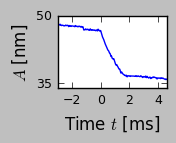

In [5]:
with mpl.rc_context(rcParams):
    fig, ax2 = plt.subplots(figsize=(1.4, 0.9))
    lock = locks[48]
    m2 = phasekick.masklh(lock.t, -1e-6, 8e-6)
    m = phasekick.masklh(lock.t, -3e-3, 4.6e-3)

    t_many = np.linspace(lock.t[m2][0], lock.t[m2][-1], 3001) * 1e6  
    ti = 16/4.0

    ax2.plot(lock.t[m]*1e3, lock.A[m])
    ax2.set_xlim(-3, 4.6)
    ax2.set_xticks(np.arange(-2, 5.25, 2))
    ax2.set_yticks(np.arange(35, 51, 15))

    # ax2.set_yticks(np.arange(35, 46, 5))
    ax2.set_ylabel("$A$ [nm]")
    ax2.set_xlabel("Time $t$ [ms]")
#     fig.savefig("/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/Avst.pdf",
#                 bbox_inches='tight', transparent=True)

In [6]:
locks = gr2locks(fh800['data'])

100%|██████████| 64/64 [00:02<00:00, 28.71it/s]


In [7]:
m800 = np.array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False, False], dtype=bool)

m400 = np.array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)

In [8]:
delay_us = delay_int / 1000.0

In [9]:
dAfunc = lambda f, tau, A0: phasekick.phase_step(1.0/f, tau, A0) * f

In [10]:
fit_func = lambda t, A1, A2, dphi, offset: A1*np.cos(2*np.pi*0.062e-3*t + dphi)*(1+A2*np.sin(2*np.pi*0.062e-3*t+dphi)) + offset

In [11]:
tt = np.arange(2000)*1e-8

In [12]:
df.sort_index(inplace=True)

In [13]:
# # plt.plot(delay_int, df.loc[idx[800, :], 'dPhi'])
# plt.plot(delay_int, df.loc[idx[400, :]*2, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[200, :]*4, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[100, :]*8, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[50, :]*16, 'dPhi'])

In [14]:
pulsewidths = np.array([800, 400, 200, 100, 50.])

In [15]:
df_i = df.xs(50, level='pulsewidth', drop_level=True)

In [16]:
dA_fit = []
dA_fit_std_err = []
dAopts = []
dAfunc_off = lambda t, A, phi, offset: offset + A*np.cos(2*np.pi*t*0.062 + 2*np.pi*phi)
for i, pulsewidth in enumerate(pulsewidths):
    df_i = df.xs(pulsewidth, level='pulsewidth', drop_level=True)
    if i == 0:
        x = df_i.index[m800]/1000.
        y = df_i.dA.values[m800]
    elif i == 1:
        x = df_i.index[m400]/1000.
        y = df_i.dA.values[m400]
    else:
        x = df_i.index/1000.
        y = df_i.dA.values

    popt, pcov = curve_fit(dAfunc_off,
    x, y, p0=[pulsewidth/40, -0.1, 0])
    dAopts.append(popt)
    dA_std_err = np.sqrt(pcov.diagonal())[0]
    dA_fit.append(popt[0])
    dA_fit_std_err.append(dA_std_err)

dA_fit = np.array(dA_fit)
dA_fit_stbd_err = np.array(dA_fit_std_err)

In [17]:
f = 1000.0/np.array(tps) # units µs^{-1}

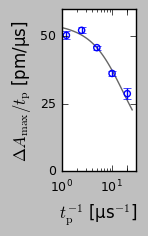

In [18]:
dA_norm = dA_fit * f
dA_norm_err = dA_fit_std_err * f
popt, pcov = optimize.curve_fit(dAfunc, f, dA_norm, sigma=dA_norm_err, p0=np.array([0.029, 53]))
f_smooth = np.linspace(1, 25, 101)
with mpl.rc_context(rcParams):
    f = 1000*pulsewidths**-1
    fig = plt.figure(figsize=(1.5, 2.4))
    plt.scatter(f, dA_fit/pulsewidths*1e3, facecolors='none', edgecolors='b')
    plt.errorbar(f, dA_fit/pulsewidths*1e3, yerr=dA_fit_std_err/pulsewidths*2 * 1e3, fmt='none')
    plt.xlabel(u"$t_\\mathrm{p}^{-1}$ [µs${}^{-1}$]")
    plt.ylabel(u"$\Delta A_{\\mathrm{max}}/t_\\mathrm{p}$ [pm/µs]")
    plt.ylim(0, 60)
    plt.yticks(np.arange(0, 55, 25))
    plt.xlim(1, 30)
    plt.xscale('log')
    plt.xticks([1, 10, 20])
#     plt.plot(f_smooth, 55/(1 + (f_smooth/20)), '0.5', zorder=0.5)
    plt.plot(f_smooth, dAfunc(f_smooth, *popt), '0.4', zorder=0)
    plt.tight_layout()
#     plt.savefig('/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/dA-vs-tp-filter-rolloff.pdf',
#                 bbox_inches='tight', transparent=True)

#     plt.savefig('/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/dA-vs-tp-filter-rolloff-fit.pdf',
#                 bbox_inches='tight', transparent=True)

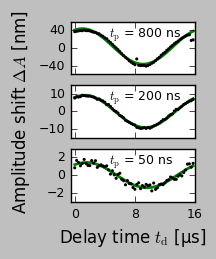

In [19]:
# fmt= dict(s=8, c='none', edgecolors='k')
fmt= dict(marker='.', c='k', edgecolors='none', zorder=1)
fmt_bestfit = dict(color='g', zorder=0, linewidth=2)

with mpl.rc_context(rcParams):
    fig, axes = plt.subplots(figsize=(1.6, 2.25), nrows=3, sharex=True)
    axes[0].plot(delay_us, dAfunc_off(delay_us, *dAopts[0]), **fmt_bestfit)
    axes[0].scatter(delay_us, df.loc[idx[800, :], 'dA'], **fmt)
    axes[0].set_yticks(np.arange(-40, 45, 40))
    axes[0].text(4.6, 24.5, "$t_\\mathrm{p}$ = 800 ns")
    
    axes[1].plot(delay_us, dAfunc_off(delay_us, *dAopts[2]), **fmt_bestfit)
    axes[1].scatter(delay_us, df.loc[idx[200, :], 'dA'], **fmt)
    axes[1].set_yticks(np.arange(-10, 15, 10))
    axes[1].text(4.6, 6.1, "$t_\\mathrm{p}$ = 200 ns")
    
    axes[2].plot(delay_us, dAfunc_off(delay_us, *dAopts[4]), **fmt_bestfit)
    axes[2].scatter(delay_us, df.loc[idx[50, :], 'dA'], **fmt)
    axes[2].text(4.6, 1.2, "$t_\\mathrm{p}$ = 50 ns")
    axes[2].set_yticks(np.arange(-2, 2.5, 2))
    axes[0].set_xlim(-0.5, 16)
    axes[2].set_xticks([0, 8, 16])
    axes[2].set_xlabel(u"Delay time $t_\\mathrm{d}$ [µs]")
    axes[1].set_ylabel(u"Amplitude shift $\\Delta A$ [nm]")
    
#     fig.savefig('/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/dA-v-td.pdf',
#                 bbox_inches='tight', transparent=True)